In [3]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline


In [4]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [5]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## 유틸리티 함수

In [7]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## PyTorch 데이터셋 생성

In [8]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [12]:
# For Dogs & Cats dataset
train_dset = ImageFolder('../Chapter03/dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('../Chapter03/dogsandcats/valid/',transform=data_transform)
classes=2

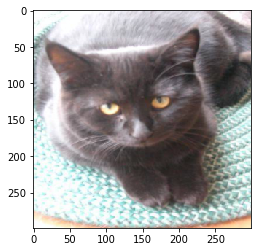

In [13]:
imshow(train_dset[150][0])

## 학습과 검증 데이터셋을 위한 데이터 로더 생성

In [14]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## ResNet 34 모델 생성

In [15]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

In [16]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

## 컨볼루션 피처 추출

In [17]:
#For training data

# Stores the labels of the train data
trn_labels = [] 

# Stores the pre convoluted features of the train data
trn_features = [] 

#Iterate through the train data and store the calculated features and the labels
for d,la in train_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data

#Iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## 학습과 검증 피처 데이터셋 생성

In [18]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## 전연결 네트워크

In [19]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [20]:
fc_in_size = 8192

In [21]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [22]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## 학습과 검증 모델

In [23]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/taewan/.local/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.49 and training accuracy is 17807/23000     77.42
validation loss is   0.4 and validation accuracy is 1659/2000     82.95
training loss is  0.36 and training accuracy is 19960/23000     86.78
validation loss is  0.32 and validation accuracy is 1778/2000      88.9
training loss is   0.3 and training accuracy is 20586/23000      89.5
validation loss is  0.28 and validation accuracy is 1818/2000      90.9
training loss is  0.26 and training accuracy is 21014/23000     91.37
validation loss is  0.24 and validation accuracy is 1845/2000     92.25
training loss is  0.23 and training accuracy is 21259/23000     92.43
validation loss is  0.22 and validation accuracy is 1864/2000      93.2
training loss is  0.21 and training accuracy is 21482/23000      93.4
validation loss is   0.2 and validation accuracy is 1877/2000     93.85
training loss is  0.19 and training accuracy is 21603/23000     93.93
validation loss is  0.19 and validation accuracy is 1875/2000     93.75
traini

In [24]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.16 and training accuracy is 21929/23000     95.34
validation loss is  0.17 and validation accuracy is 1895/2000     94.75
training loss is  0.15 and training accuracy is 22005/23000     95.67
validation loss is  0.16 and validation accuracy is 1898/2000      94.9
training loss is  0.14 and training accuracy is 22001/23000     95.66
validation loss is  0.15 and validation accuracy is 1900/2000      95.0
training loss is  0.13 and training accuracy is 22073/23000     95.97
validation loss is  0.15 and validation accuracy is 1904/2000      95.2
training loss is  0.13 and training accuracy is 22130/23000     96.22
validation loss is  0.15 and validation accuracy is 1904/2000      95.2
training loss is  0.12 and training accuracy is 22225/23000     96.63
validation loss is  0.14 and validation accuracy is 1906/2000      95.3
training loss is  0.12 and training accuracy is 22193/23000     96.49
validation loss is  0.15 and validation accuracy is 1885/2000     94.25
traini

In [25]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.11 and training accuracy is 22306/23000     96.98
validation loss is  0.12 and validation accuracy is 1915/2000     95.75
training loss is   0.1 and training accuracy is 22311/23000      97.0
validation loss is  0.12 and validation accuracy is 1919/2000     95.95
training loss is 0.098 and training accuracy is 22364/23000     97.23
validation loss is  0.12 and validation accuracy is 1922/2000      96.1
training loss is 0.096 and training accuracy is 22393/23000     97.36
validation loss is  0.12 and validation accuracy is 1919/2000     95.95
training loss is 0.092 and training accuracy is 22451/23000     97.61
validation loss is  0.11 and validation accuracy is 1925/2000     96.25
training loss is  0.09 and training accuracy is 22445/23000     97.59
validation loss is  0.11 and validation accuracy is 1918/2000      95.9
training loss is 0.087 and training accuracy is 22433/23000     97.53
validation loss is  0.13 and validation accuracy is 1922/2000      96.1
traini

In [26]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.081 and training accuracy is 22512/23000     97.88
validation loss is   0.1 and validation accuracy is 1929/2000     96.45
training loss is  0.08 and training accuracy is 22500/23000     97.83
validation loss is 0.097 and validation accuracy is 1934/2000      96.7
training loss is 0.077 and training accuracy is 22520/23000     97.91
validation loss is 0.097 and validation accuracy is 1932/2000      96.6
training loss is 0.076 and training accuracy is 22529/23000     97.95
validation loss is 0.095 and validation accuracy is 1933/2000     96.65
training loss is 0.073 and training accuracy is 22544/23000     98.02
validation loss is 0.093 and validation accuracy is 1934/2000      96.7
training loss is 0.074 and training accuracy is 22537/23000     97.99
validation loss is 0.093 and validation accuracy is 1936/2000      96.8
training loss is 0.069 and training accuracy is 22602/23000     98.27
validation loss is 0.094 and validation accuracy is 1939/2000     96.95
traini